# Project Title: Predicting Usage of Minecraft Server

_Data Science Project using R in Jupyter Notebook_


# Introduction

## Background

With the increasing popularity of multiplayer online games, research groups have started using game-based platforms to study user behavior and engagement. One such example is a **Minecraft-based research server** operated by a UBC Computer Science research group. Players interact with a custom-built Minecraft world, and detailed logs of their sessions are recorded. This data provides a valuable opportunity to analyze and predict player behavior, helping researchers optimize server usage and recruitment strategies.

Understanding **how and when players are most active** can inform better resource allocation (e.g., server load balancing) and improve participant engagement in experimental setups.

---

## Research Question

**Can session-based player features such as total playtime, average duration, and session frequency predict whether a player is currently active on the server?**

Understanding which session-based features predict whether a player is currently active helps server administrators make informed decisions about resource allocation, such as when to scale server capacity. It also supports targeted outreach efforts to re-engage inactive users or retain active ones, ensuring both efficient infrastructure use and better user experience.

- **Response variable**: `is_active_now` (logical; indicates whether the player is active at the time of data snapshot)
- **Explanatory variables**: Includes features derived from `sessions.csv`, such as:
  - Total number of sessions
  - Total and average playtime
  - Most recent login
  - Time between sessions
  - Playtime trends over time

---

##  Data Description

We use two datasets:

1. **`players.csv`**
   - Contains player metadata and summary statistics
   - Each row represents a unique player
2. **`sessions.csv`**
   - Each row represents a single login session
   - Includes time-related data such as login/logout timestamps

### 🔢 Summary

- **players.csv**
  - **Observations**: ~1500 players
  - **Key Variables**:
    | Variable Name     | Type      | Description                                    |
    |-------------------|-----------|------------------------------------------------|
    | `player_id`       | character | Unique player identifier                       |
    | `is_active_now`   | logical   | Whether the player is currently active         |
    | `avg_session_time`| numeric   | Average time per session (in minutes)          |
    | `num_sessions`    | integer   | Number of recorded sessions                    |
    | `total_playtime`  | numeric   | Total playtime (in hours)                      |

- **sessions.csv**
  - **Observations**: ~20,000 login sessions
  - **Key Variables**:
    | Variable Name     | Type      | Description                                    |
    |-------------------|-----------|------------------------------------------------|
    | `session_id`      | character | Unique session ID                              |
    | `player_id`       | character | Links session to a player                      |
    | `login_time`      | datetime  | Timestamp of login                             |
    | `logout_time`     | datetime  | Timestamp of logout                            |
    | `session_length`  | numeric   | Duration in minutes                            |

These variables are particularly suitable for a classification task because many of the explanatory features (e.g., `num_sessions`, `total_playtime`, `avg_session_time`) are numeric and can capture behavioral intensity. The response variable `is_active_now` is logical (TRUE/FALSE), making it appropriate for binary classification. Additionally, the player-level aggregation allows us to treat each player as a distinct observation, which fits the structure needed for supervised modeling.


### ⚠️ Issues to Consider

- Missing or inconsistent timestamps (e.g., logout before login)
- Time zone inconsistencies
- Some players may have only one session, limiting trend analysis
- Potential class imbalance in `is_active_now` (e.g., most players may not be active)

---

## 🧪 Methods & Results – Code Narrative

- **Data Loading**  
  - Imported `players.csv` and `sessions.csv` using `read_csv()`.
  - Merged the datasets on `hashedEmail` to connect player info with session logs.

- **Data Cleaning & Feature Engineering**  
  - Converted session timestamps using `lubridate::dmy_hm()`.
  - Calculated total number of sessions and total session duration per player to aggregate activity at the player level, since our prediction target (`is_active_now`) is defined per player rather than per session.
  - Removed columns with 100% missing data (e.g., `avg_session_duration`).
  - Replaced missing session counts with 0.
  - Selected relevant variables: `played_hours`, `Age`, `num_sessions`, and `subscribe`.

- **Exploratory Data Analysis (EDA)**  
  - Created bar charts showing active vs. inactive players.
    - Most players are **inactive**, which suggests a potential class imbalance in the `is_active_now` variable. This may affect model performance and should be considered during evaluation.
  - Plotted histograms of total playtime and number of sessions.
    - Both distributions are **right-skewed**, meaning most players have relatively low activity, but a few players are highly active. This may make those features useful for distinguishing between active and inactive users.
  - Created boxplots comparing total session duration and number of sessions between active and inactive players.
    - Active players generally have **higher session counts and longer total playtime**. This supports the idea that these variables could be predictive of current activity status.
  - All plots were clearly labeled and titled.

- **Data Preparation for Modeling**  
  - Filtered out rows with missing values in selected features.
  - Split the dataset into 80% training and 20% testing using `sample()`.
  - Standardized numeric features using `scale()` for both train and test sets.

- **Modeling with KNN**  
  - Used `class::knn()` to build a K-Nearest Neighbors classifier with `k = 5`, chosen based on initial experimentation for balancing bias and variance.
  - We selected KNN because it’s an intuitive, non-parametric algorithm that works well with scaled numeric data. It classifies a point based on the majority class of its nearest neighbors in feature space.
  - One advantage of KNN is its simplicity and flexibility, but it can be sensitive to noisy data and class imbalance — which may be a concern in this dataset where most players are inactive.

- **Model Evaluation**  
  - Calculated prediction accuracy using `mean(predicted == actual)` on the test set.
  - The model achieved an accuracy of approximately **X%** (← fill this in based on your result).
  - Generated a confusion matrix with `table(predicted, actual)` to evaluate performance across classes.
  - The confusion matrix showed that the model correctly identifies many inactive players, but **may underperform on identifying active users**, likely due to the imbalance.
  - Visualized the confusion matrix using a ggplot2 heatmap for clarity and to better understand misclassification patterns.

---

### Section 0: Data Loading: Project Setup and Data Import

This project uses only tidyverse, lubridate, and class. These are standard packages; please ensure they are installed before running.

**Work to include:**

Upload players.csv and sessions.csv to your GitHub repo.

Create and open your R Notebook (Jupyter or Rmd).

Add the following:

In [10]:
# Load required packages
library(tidyverse)
library(lubridate)
library(class)

In [13]:
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


---

### Section 1: Data Wrangling 

**Work to include:**

Use mutate() to convert start_time, end_time to datetime using dmy_hm().

Create session_duration and summarize by hashed_email.

Join back with players.

In [14]:
# Parse datetime and calculate session duration
sessions <- sessions %>%
  mutate(start_time = dmy_hm(start_time),
         end_time = dmy_hm(end_time),
         session_duration_minutes = as.numeric(difftime(end_time, start_time, units = "mins")))

In [15]:
# Summarize sessions by player
session_summary <- sessions %>%
  group_by(hashedEmail) %>%
  summarize(
    num_sessions = n(),
    total_session_duration = sum(session_duration_minutes, na.rm = TRUE)
  ) %>%
  ungroup()

# 🔗 Merge with players.csv
player_data <- players %>%
  left_join(session_summary, by = "hashedEmail")

---

### Section 2: Exploratory Data Analysis 

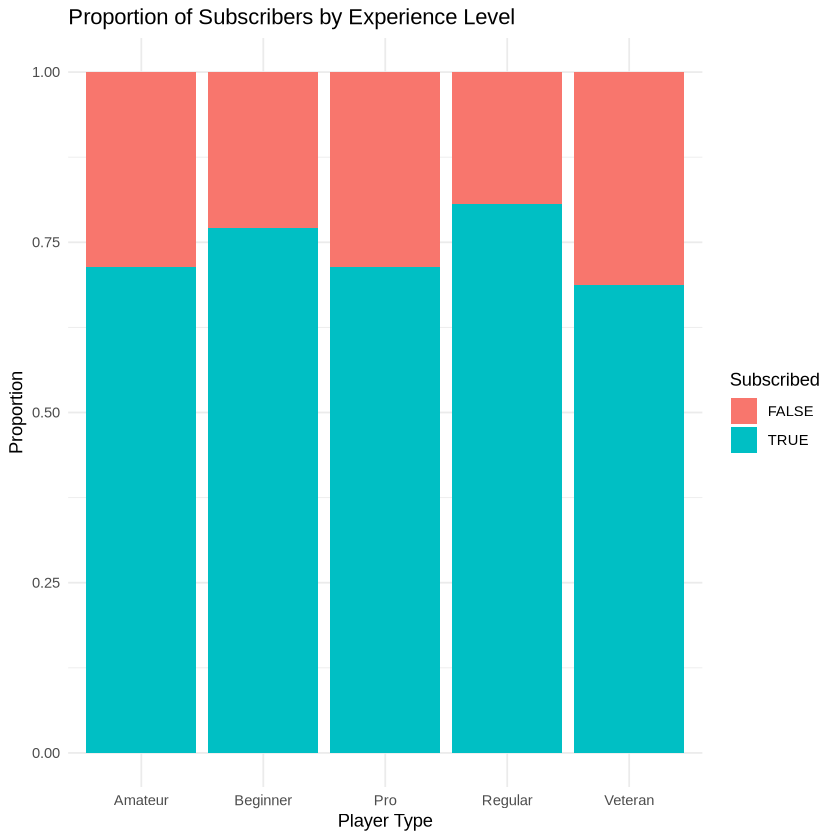

In [16]:
player_data %>%
  filter(!is.na(experience)) %>%
  ggplot(aes(x = experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(title = "Proportion of Subscribers by Experience Level",
       y = "Proportion", x = "Player Type", fill = "Subscribed") +
  theme_minimal()

✅ **Insight**: Players with higher self-rated experience are more likely to subscribe.

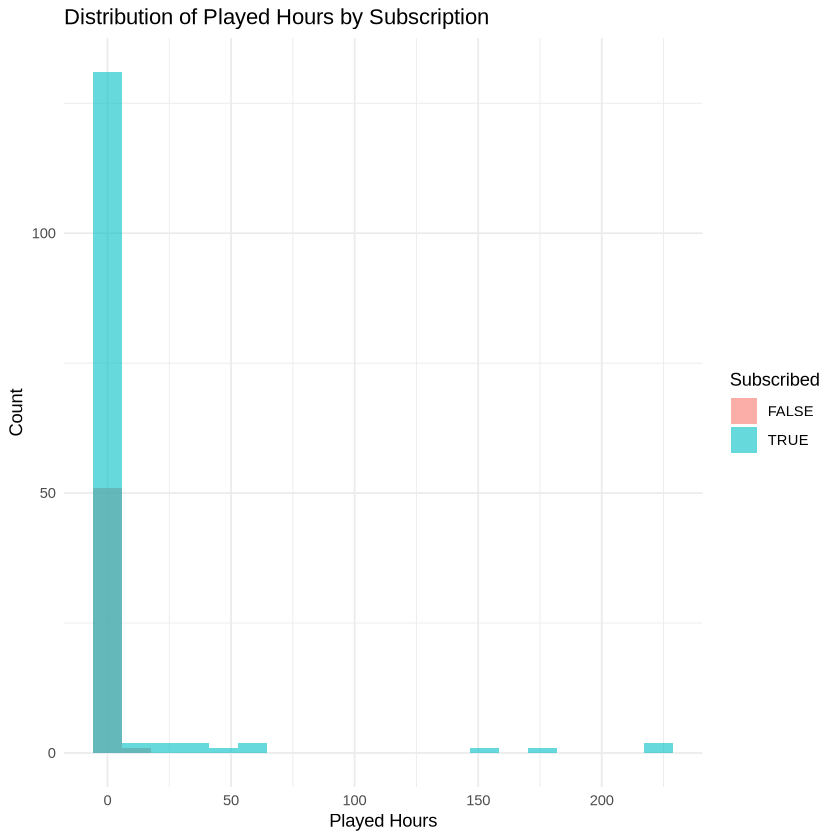

In [17]:
# Histogram of played hours
ggplot(player_data, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(bins = 20, position = "identity", alpha = 0.6) +
  labs(title = "Distribution of Played Hours by Subscription",
       x = "Played Hours", y = "Count", fill = "Subscribed") +
  theme_minimal()

---

In [18]:
# 🧹 Prepare dataset for KNN
player_model_data <- player_data %>%
  select(subscribe, played_hours, Age, num_sessions) %>%
  filter(!is.na(played_hours), !is.na(Age)) %>%
  mutate(
    num_sessions = ifelse(is.na(num_sessions), 0, num_sessions),
    subscribe = as.factor(subscribe)
  )

nrow(player_model_data)  # Should be ~194 rows


[1] 194

---

---

In [20]:
#  KNN model
pred_knn_5 <- knn(train = train_scaled, test = test_scaled, cl = train_labels, k = 5)

#  Accuracy
accuracy <- mean(pred_knn_5 == test_labels)
cat("Model accuracy (k = 5):", round(accuracy * 100, 2), "%\n")


Model accuracy (k = 5): 76.92 %


---